In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import signal
# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

In [2]:
grodf = pd.read_csv('data/grocery_store_data_cleaned.csv')

In [3]:
grodf['DATE'] = pd.to_datetime(grodf['DATE'])
grodf.set_index('DATE', inplace=True)

In [5]:
grodf.drop(columns='Unnamed: 0',inplace = True)
grodf.columns

Index(['TICKET', 'UNITS', 'REFERENCE', 'CODE', 'NAME', 'UNIT_PRICEBUY',
       'UNIT_PRICESELL', 'PAYMENT', 'TRANSID', 'CATEGORY', 'TOTAL_PRICEBUY',
       'TOTAL_PRICESELL', 'UNIT_PRICE_MARGIN', 'PROFIT'],
      dtype='object')

In [6]:
grodf[grodf.PAYMENT=='free'].sum()

TICKET               9c178cbd-5b82-4981-be92-5e8b26fb14419c178cbd-5...
UNITS                                                           37.866
REFERENCE                                                        82684
CODE                                                       4.20816e+13
NAME                 egg free range 600gCapsicum redGarlic 500gCarr...
UNIT_PRICEBUY                                                     87.4
UNIT_PRICESELL                                                  230.72
PAYMENT              freefreefreefreefreefreefreefreefreefreefreefr...
TRANSID              no IDno IDno IDno IDno IDno IDno IDno IDno IDn...
CATEGORY             EggscapsicumOnionscarrotsMushroomsCitrusPearsO...
TOTAL_PRICEBUY                                                 39.2848
TOTAL_PRICESELL                                                129.662
UNIT_PRICE_MARGIN                                               143.32
PROFIT                                                          90.377
dtype:

In [11]:
grodf.drop(grodf.index[grodf.PAYMENT=='free'],inplace = True)

In [12]:
grodf.PAYMENT.unique()

array(['cash', 'cashrefund', 'magcard'], dtype=object)

In [22]:
grodf.drop(grodf.index[grodf.CATEGORY == 'markdown bag'],inplace = True)

I drop markdown bags

In [23]:
cats = grodf.groupby('CATEGORY')

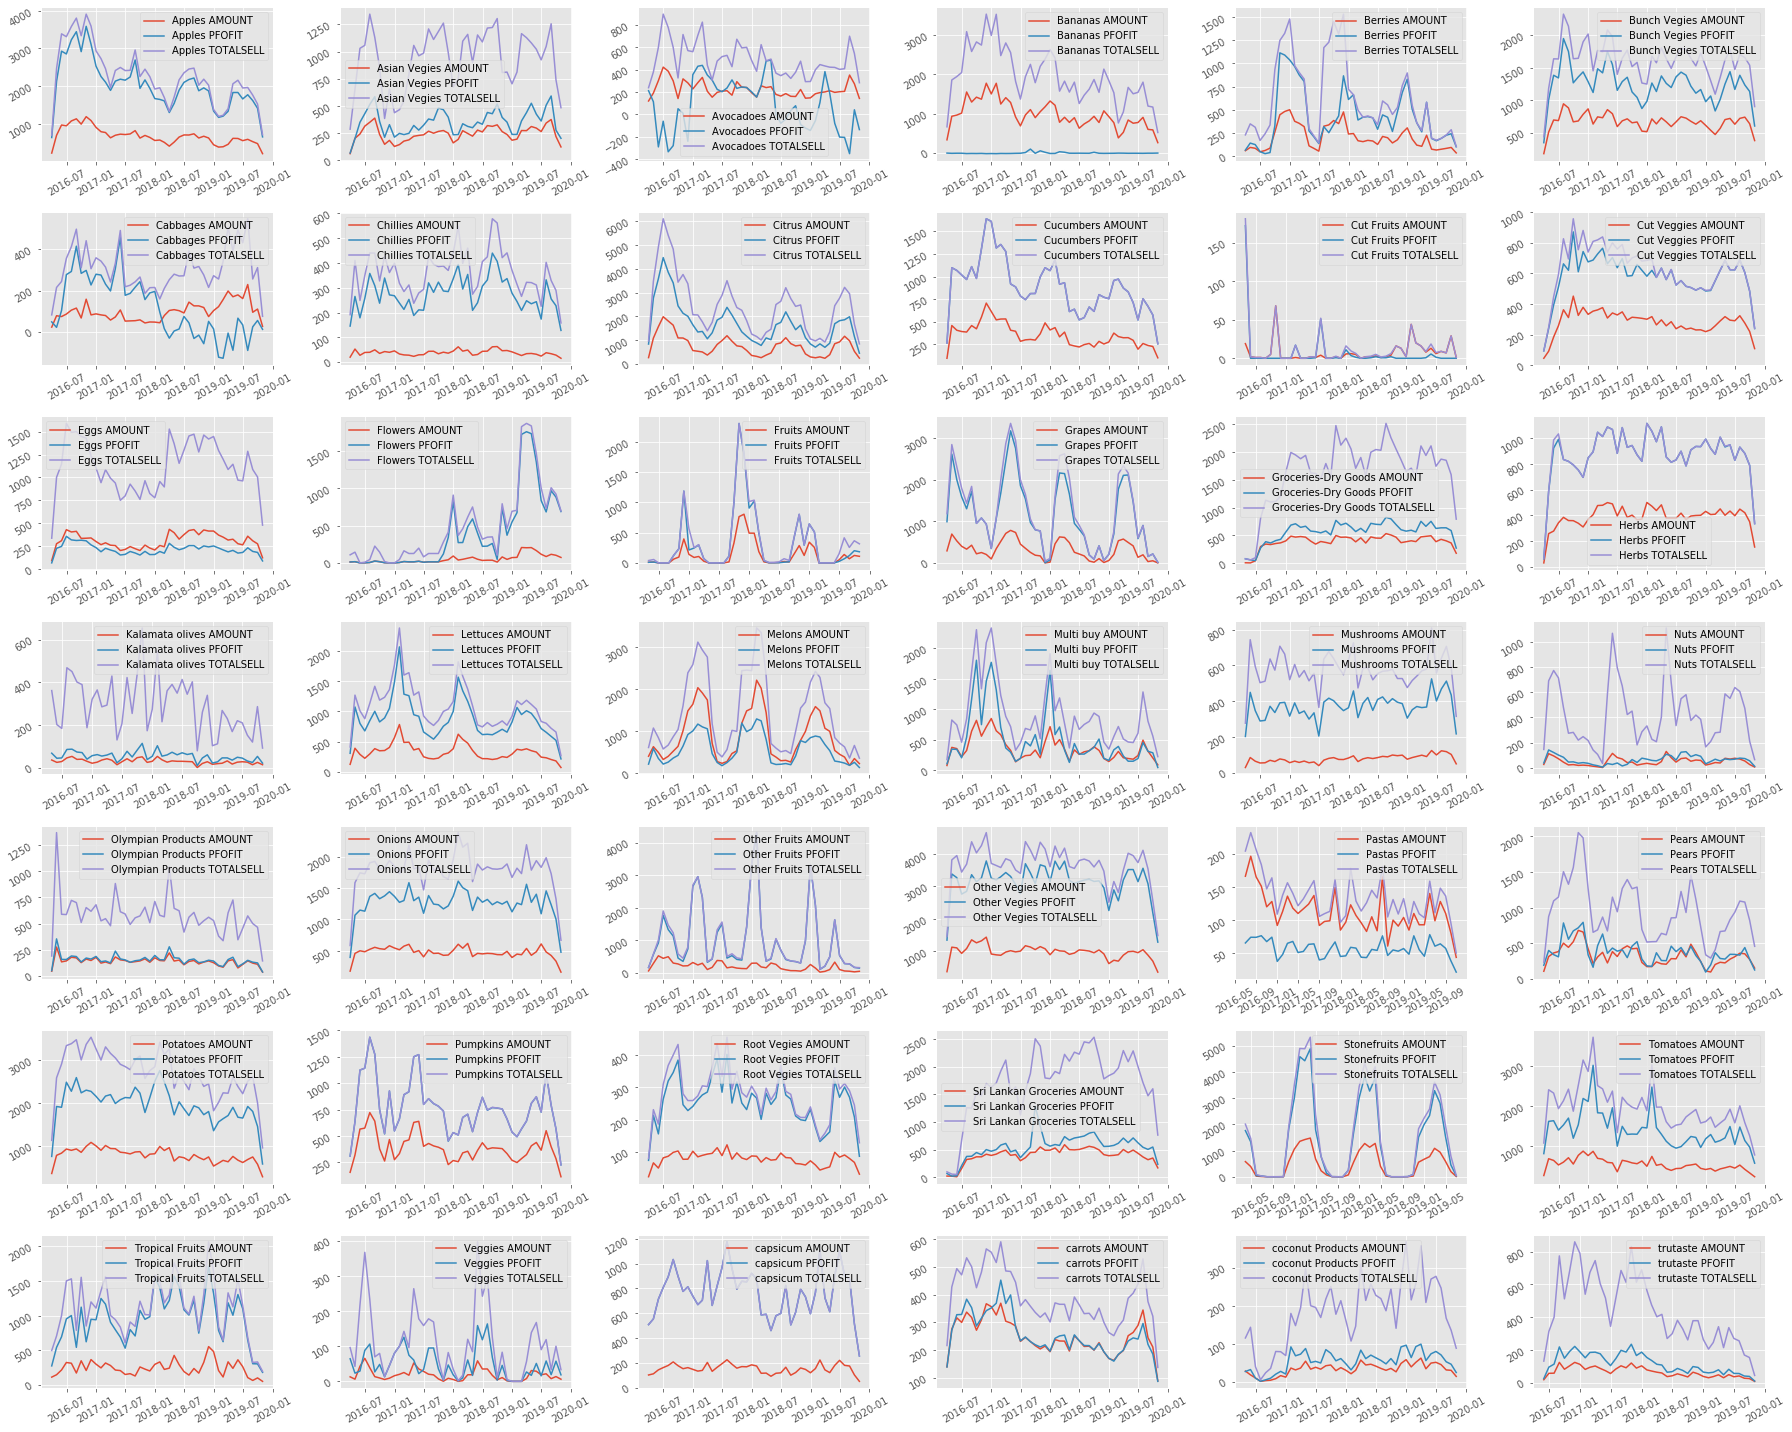

In [24]:
fig, axes = plt.subplots(7,6,figsize = (25,20))
#plt.setp(axes.xaxis.get_majorticklabels(), rotation=45)
for cat,ax in zip(cats, axes.flatten()):
    ax.plot(cat[1].resample('M').sum()['UNITS'], label = cat[0]+' AMOUNT')
    ax.plot(cat[1].resample('M').sum()['PROFIT'], label = cat[0]+' PFOFIT')
    ax.plot(cat[1].resample('M').sum()['TOTAL_PRICESELL'], label = cat[0]+' TOTALSELL')
    ax.legend()
    ax.tick_params(labelrotation=30)
#plt.xticks(rotation=45)
plt.tight_layout()

lets try to create some model
starts with one category
say pears

In [25]:
pears = grodf[grodf.CATEGORY == 'Pears']
pears.shape

(15554, 14)

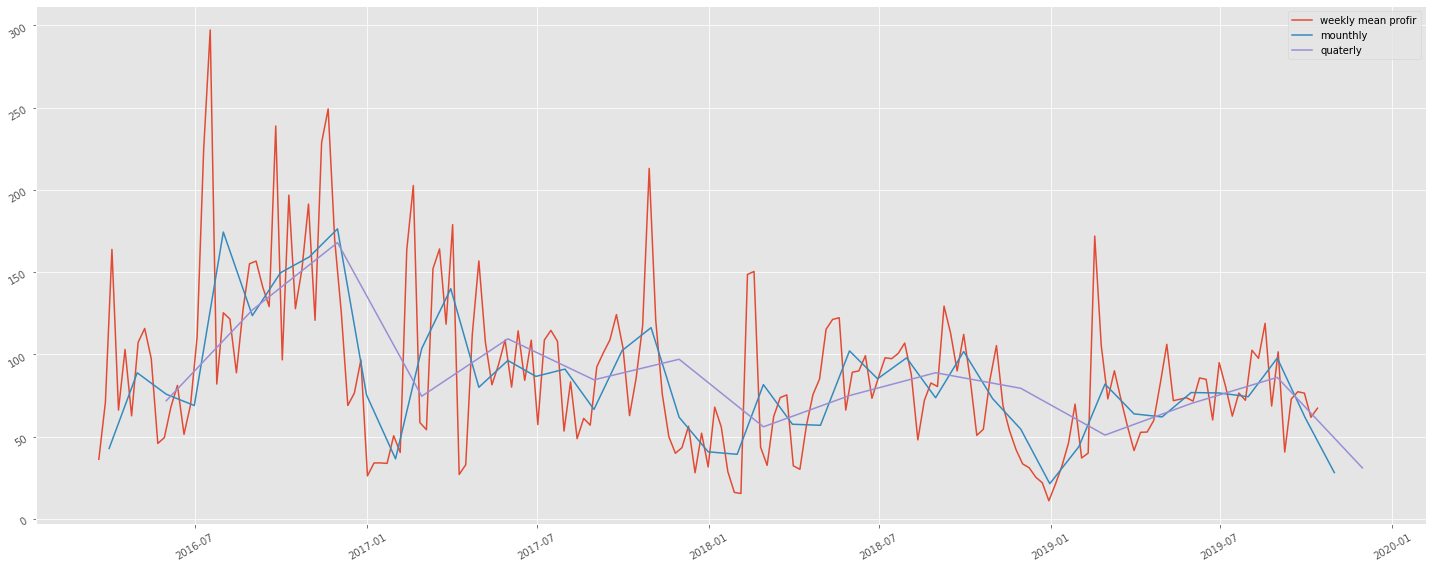

In [37]:
fig, ax = plt.subplots(figsize = (20,8))
ax.plot(pears.resample('W').sum()['PROFIT'], label = 'weekly mean profir')
ax.plot(pears.resample('M').sum()['PROFIT']/4.5, label = 'mounthly')
ax.plot(pears.resample('Q-NOV').sum()['PROFIT']/13, label = 'quaterly')

ax.legend()
ax.tick_params(labelrotation=30)
#plt.xticks(rotation=45)
plt.tight_layout()

In [38]:
pears_prof_week = pears.resample('W').sum()['PROFIT']

In [40]:
len(pears_prof_week)

187

In [44]:
times = pd.DataFrame({'times^1':np.linspace(0,1, 187)})
times = sm.add_constant(times)
n = 25
for x in range(2, n+1):
    col_n = 'times^'+str(x)
    col_s = 'times^'+str(x-1)
    times[col_n] = times['times^1']*times[col_s]

lets fit OLS model for week profits

In [47]:
results = []
for x in range(1,n+1):
    model = sm.OLS(pears_prof_week.values, times.iloc[:,:x+1])
    #models.append(model)
    results.append(model.fit())

In [50]:
### Whats AIC BIC???
aic=[]
bic =[]

for res  in results:
    aic.append(res.aic)
    bic.append(res.bic)
AICBIC = pd.DataFrame({'aic': aic, 'bic':bic}, index=range(1,n+1))    
AICBIC['a_o_b']= AICBIC['aic']/AICBIC['bic']
AICBIC.T

,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
aic,1958.582511,1958.801947,1954.985399,1950.489468,1946.527022,1947.445033,1946.986780,1948.931248,1947.575516,1942.243180,...,1937.799820,1939.775936,1940.717332,1940.794796,1937.296008,1936.442660,1938.307253,1938.068890,1937.046529,1937.750600
bic,1965.044728,1968.495273,1967.909833,1966.645011,1965.913673,1970.062793,1972.835649,1978.011226,1979.886602,1977.785375,...,1992.728667,1997.935891,2002.108396,2005.416969,2001.918180,2001.064832,2006.160534,2005.922171,2004.899810,2008.834989
a_o_b,0.996711,0.995076,0.993432,0.991785,0.990139,0.988519,0.986898,0.985298,0.983680,0.982029,...,0.972435,0.970890,0.969337,0.967776,0.967720,0.967706,0.966178,0.966174,0.966156,0.964614


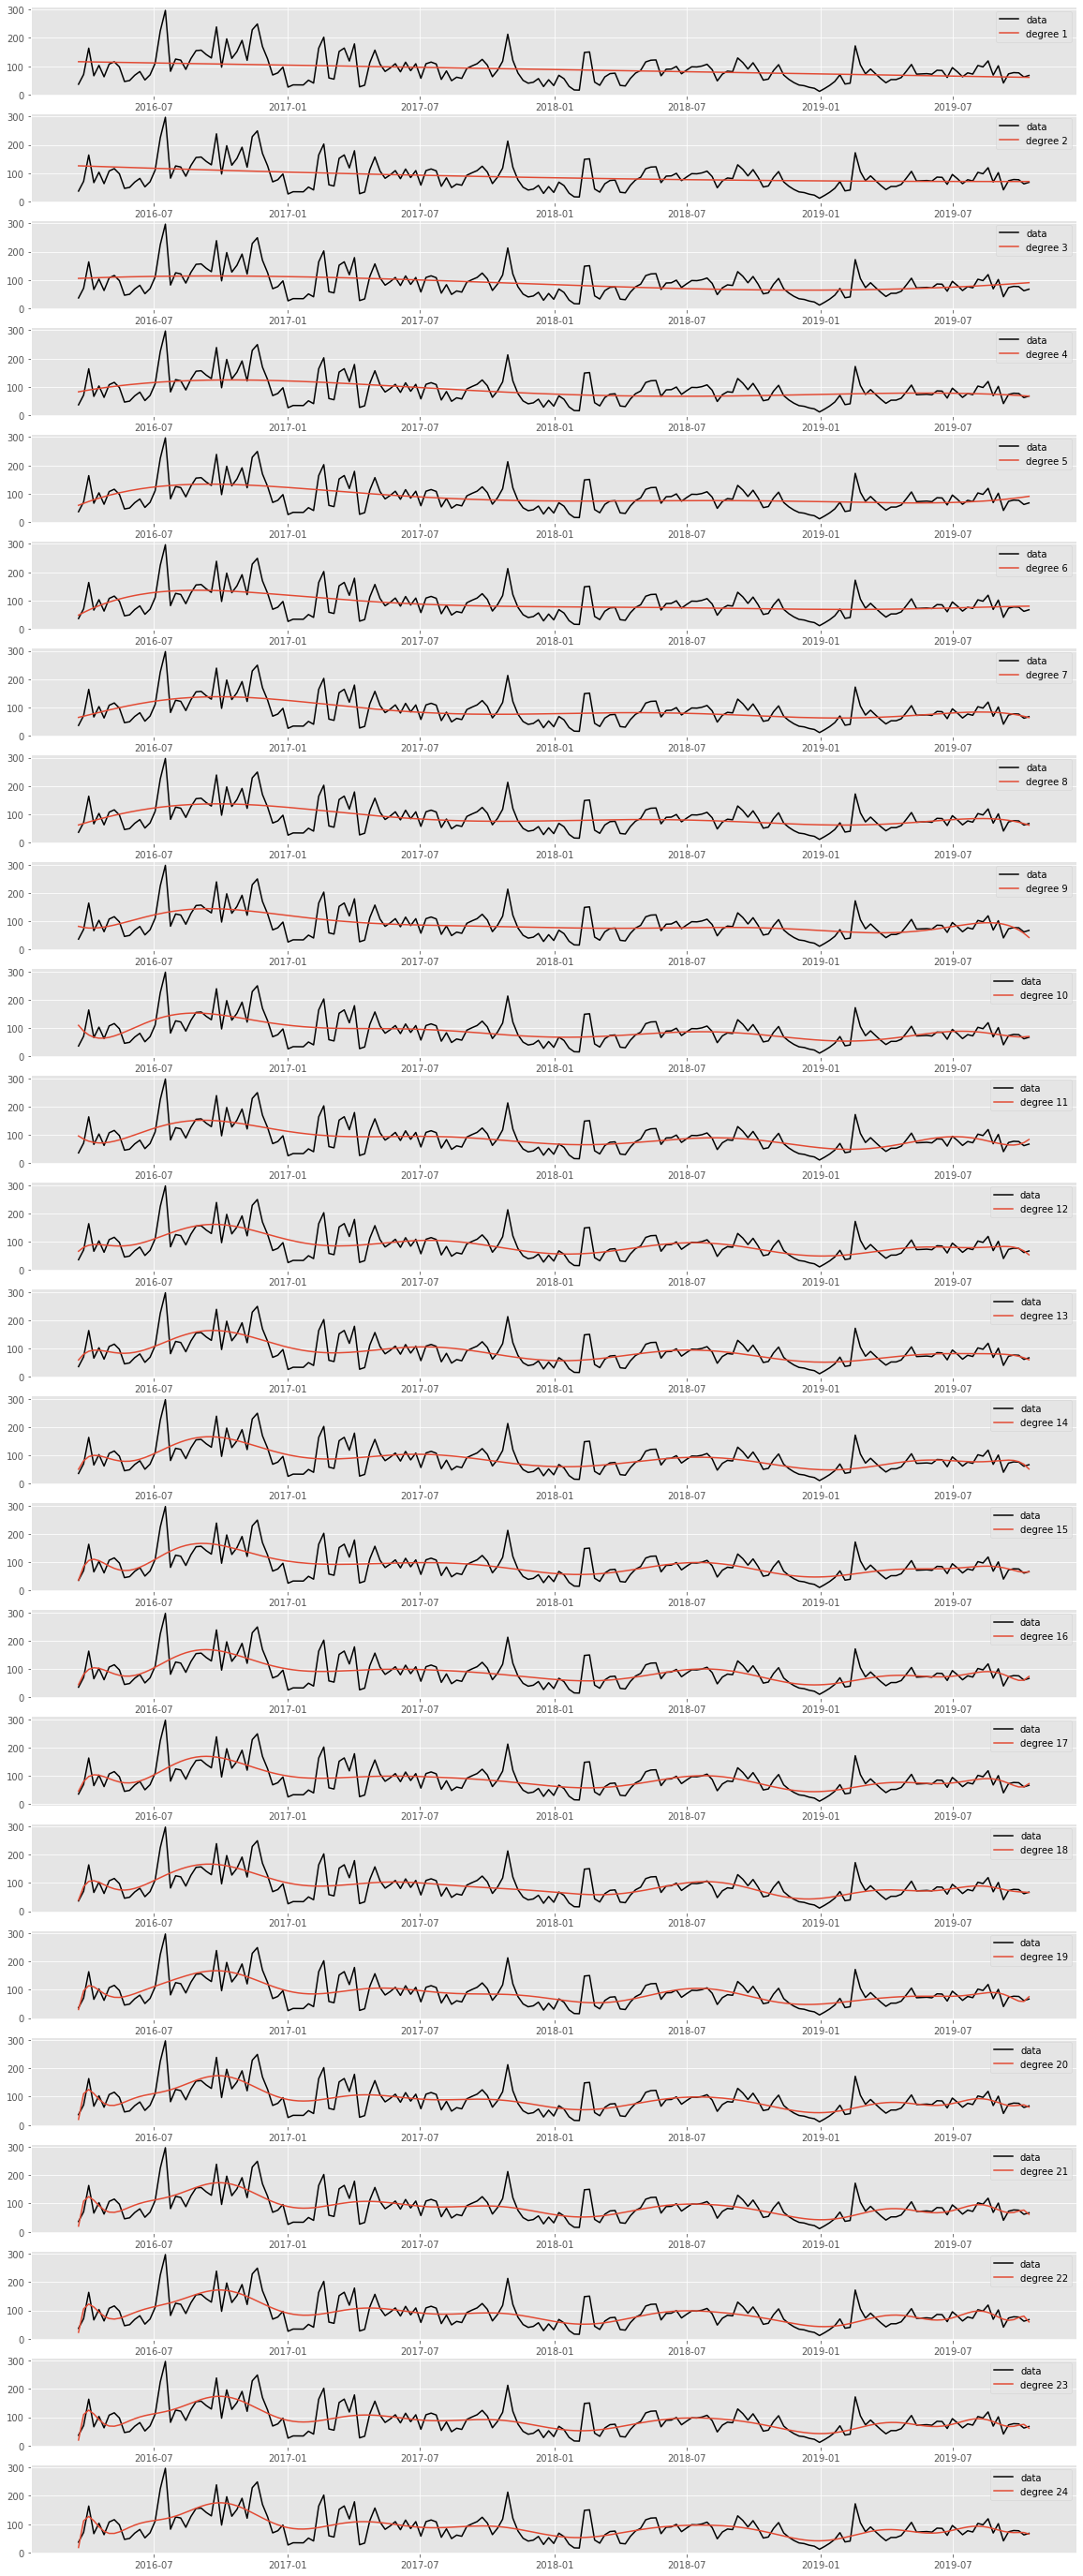

In [49]:
fig, axs = plt.subplots(24, 1 , figsize = (20,50))
for model, ax in zip(results, axs.flatten()):
    ax.plot(pears_prof_week, label = 'data', color = 'black')
    degree = len(model.params)-1
    ax.plot(pears_prof_week.index, model.fittedvalues, label = 'degree ' + str(degree))
    
    ax.legend()

so degree between 10 and 20 looks promising

In [ ]:
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).ix[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)